## 1. Data Processing

In [43]:
pip install tensorflow

python3.13(29353) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached markdown-3.8.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached namex-0.1.0-py3-none-any.whl.metadata (322 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.7/200.7 MB 10.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 12.2 MB/s eta

In [21]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [22]:
def load_and_resize_image(file_path, target_shape=(128, 128)):
  image = cv2.imread(file_path)
  resized_image = cv2.resize(image, target_shape)
  return resized_image

def load_image_class_by_directory(image_dir):
    image_files = os.listdir(image_dir)
    images = []
    for file in image_files:
        if file.endswith('.jpg') or file.endswith('.JPG'):  
            image_path = os.path.join(image_dir, file)
            resized_image = load_and_resize_image(image_path)  
            images.append(resized_image)
    print(f"Num of images: {len(images)}")
    print(f"Single image shape before flattening: {images[0].shape}")
    return images

In [23]:
def display_images(images, num_images_to_display=6):
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 5))
    
    for i in range(num_images_to_display):
        if i >= len(images):
            break
            
        image = images[i].astype(np.uint8)
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  
        axes[i].axis('off')
    
    plt.show()


Num of images: 1145
Single image shape before flattening: (128, 128, 3)


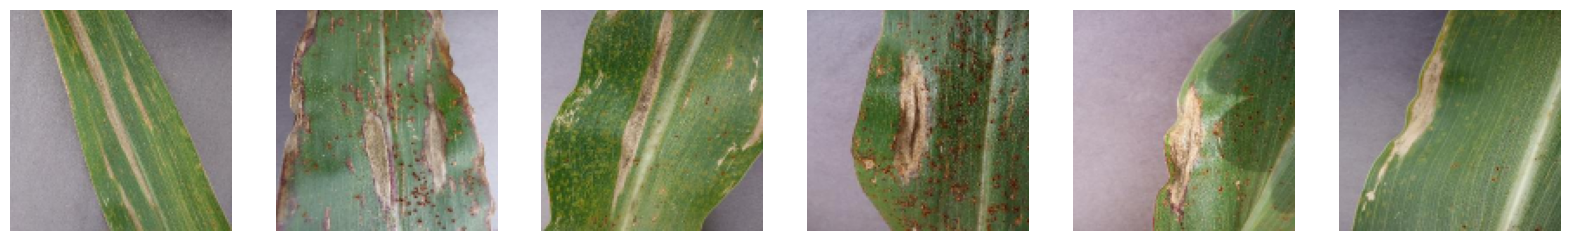

Num of images: 1306
Single image shape before flattening: (128, 128, 3)


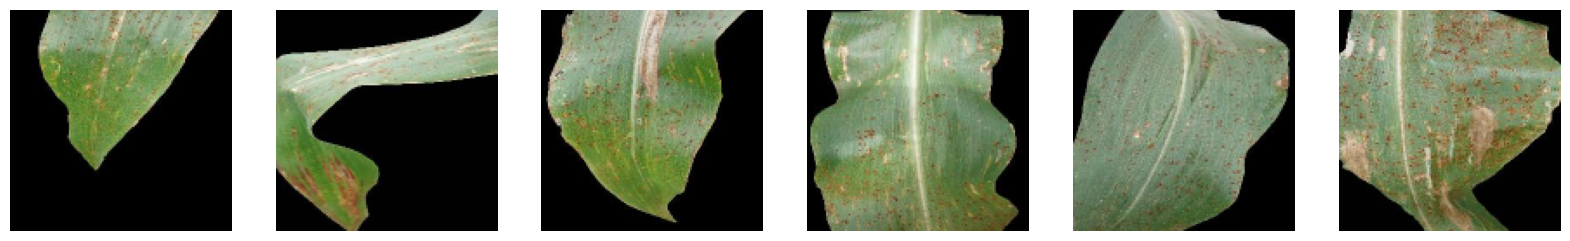

Num of images: 574
Single image shape before flattening: (128, 128, 3)


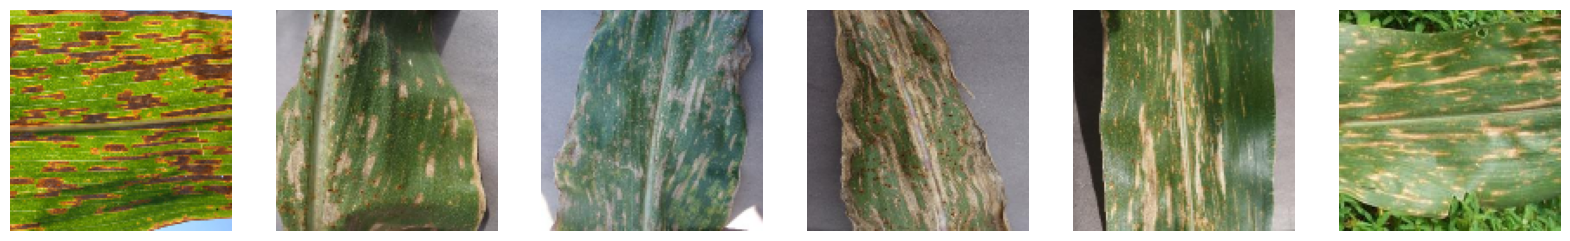

Num of images: 1162
Single image shape before flattening: (128, 128, 3)


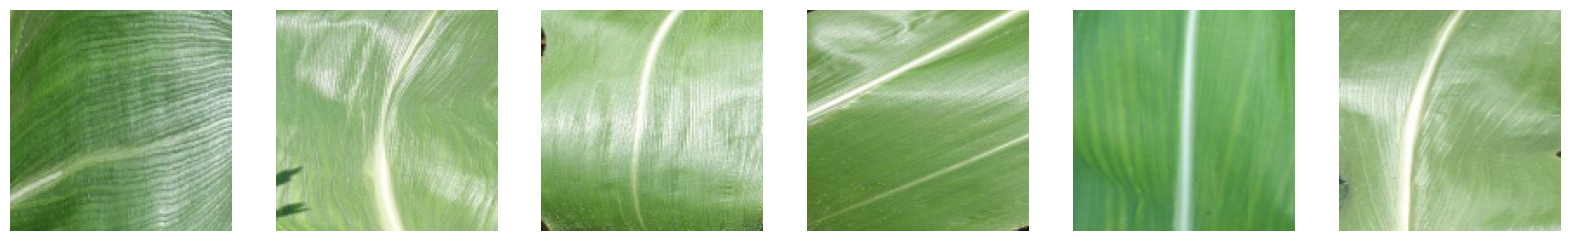

In [24]:
image_dir = "/Users/sonu/Downloads/data/Blight"
images_Blight = load_image_class_by_directory(image_dir)
display_images(images_Blight)
image_dir = "/Users/sonu/Downloads/data/Common_Rust"
images_Common_Rust = load_image_class_by_directory(image_dir)
display_images(images_Common_Rust)
image_dir = "/Users/sonu/Downloads/data/Gray_Leaf_Spot"
images_Gray_Leaf_Spot = load_image_class_by_directory(image_dir)
display_images(images_Gray_Leaf_Spot)
image_dir = "/Users/sonu/Downloads/data/Healthy"
images_Healthy = load_image_class_by_directory(image_dir)
display_images(images_Healthy)

Disease: Blight --- Images: 1145


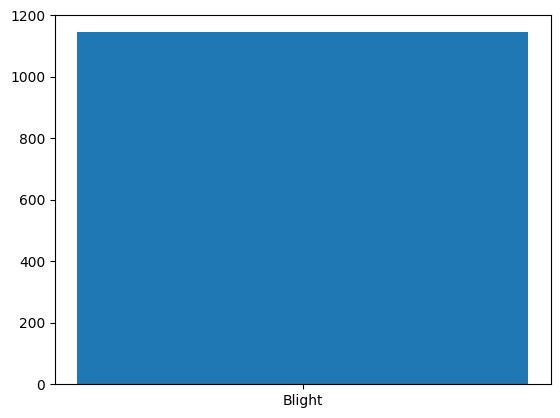

Disease: Common_Rust --- Images: 1306


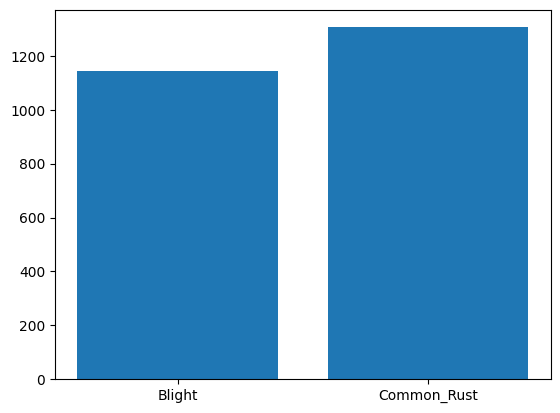

Disease: Gray_Leaf_Spot --- Images: 574


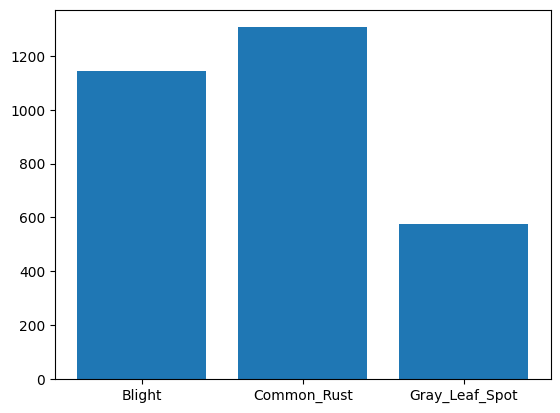

Disease: Healthy --- Images: 1162


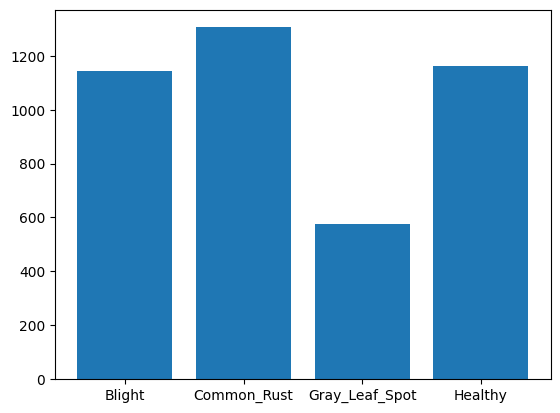

In [25]:

classes = {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}
inverted_classes = {0: 'Blight', 1: 'Common_Rust', 2: 'Gray_Leaf_Spot', 3: 'Healthy'}
images_lst_lst = [images_Blight, images_Common_Rust, images_Gray_Leaf_Spot, images_Healthy]
classes_dict = {}
for i, images in enumerate(images_lst_lst):
   classes_dict.update({inverted_classes[i]: len(images)})
   print(f'Disease: {inverted_classes[i]} --- Images: {len(images)}')
   plt.bar(*zip(*classes_dict.items()))
   plt.show()




## 2. Feature Engineering

In [26]:
def flatten_images(images):
    data_flattened = []
    for image in images:
        flattened_image = image.reshape(-1)  
        data_flattened.append(flattened_image)
    print(f"Num of images: {len(data_flattened)}")
    print(f"Single image shape after flattening: {data_flattened[0].shape}")
    data_flattened = np.array(data_flattened)
    return data_flattened

def assign_image_class_label(images, class_label=int):
    data_labeled = []
    data_flattened = flatten_images(images)
    for image in data_flattened:
        data_labeled.append(np.concatenate([image, [class_label]]))
    print(f"Num of images: {len(data_labeled)}")
    print(f"Single data shape with label: {data_labeled[0].shape} --- Class label: {class_label}\n")
    data_labeled = np.array(data_labeled)
    return data_labeled

def concat_arrays_to_dataframe(arrays=[]):
    dataset = np.concatenate(arrays, axis=0)
    num_pix = dataset.shape[1] - 1
    col_lst = [f"pixel{col}" for col in range(num_pix)]
    col_lst.append("label")
    df_dataset = pd.DataFrame(dataset, columns=col_lst)
    return df_dataset

In [27]:

from sklearn.utils import resample

def oversample_minority_class(images_lst_array, minority_class_index, target_count):
    original_count = len(images_lst_array[minority_class_index])
    
    samples_to_add = target_count - original_count
    
    if samples_to_add > 0:
        minority_samples = images_lst_array[minority_class_index]
        oversampled = resample(minority_samples, 
                                replace=True,  
                                n_samples=samples_to_add, 
                                random_state=42)
        images_lst_array[minority_class_index] = np.vstack((minority_samples, oversampled))
    
    return images_lst_array



## 3. Divid Training-set and Test-set

In [28]:
def split_train_test_files(images_lst_lst = [], num_test_set = int):
   train_images_lst_lst = []
   test_images_lst_lst = []
   for images in images_lst_lst:
      train_set = images[num_test_set:]
      test_set = images[:num_test_set]
      train_images_lst_lst.append(train_set)
      test_images_lst_lst.append(test_set)
   return train_images_lst_lst, test_images_lst_lst


In [29]:
num_test_set = 20

train_images, test_images = split_train_test_files(images_lst_lst, num_test_set)

images_lst_array = []
for i, images in enumerate(train_images):
    labeled = assign_image_class_label(images, i)
    images_lst_array.append(labeled)


Num of images: 1125
Single image shape after flattening: (49152,)
Num of images: 1125
Single data shape with label: (49153,) --- Class label: 0

Num of images: 1286
Single image shape after flattening: (49152,)
Num of images: 1286
Single data shape with label: (49153,) --- Class label: 1

Num of images: 554
Single image shape after flattening: (49152,)
Num of images: 554
Single data shape with label: (49153,) --- Class label: 2

Num of images: 1142
Single image shape after flattening: (49152,)
Num of images: 1142
Single data shape with label: (49153,) --- Class label: 3



In [30]:
target_count = max(len(images) for images in train_images)  
images_lst_array = oversample_minority_class(images_lst_array, 2, target_count)  

In [31]:
print("Total number of categories:", len(images_lst_array))  

Total number of categories: 4


In [32]:
print("Type of train_images:", type(train_images))
print("Length of train_images:", len(train_images))  
print("Type of first element:", type(train_images[1]))
print("Length of first element:", len(train_images[1])) 

Type of train_images: <class 'list'>
Length of train_images: 4
Type of first element: <class 'list'>
Length of first element: 1286


In [33]:
df_images = concat_arrays_to_dataframe(images_lst_array)
df_images.head(10)

pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0     133     117     124     132     116     123     134     118     125   
1     135     120     128     133     118     126     133     118     126   
2      36      66      53      39      69      56      55      84      69   
3     133     118     126     136     121     129     140     125     133   
4      71      86     102     100     116     132      99     118     133   
5      16      22      17      16      22      19      16      21      19   
6     161     155     166     169     163     174     170     164     175   
7     108     123     121      94     115     114      91     123     120   
8     139     131     142     140     132     143     142     134     145   
9     109     124      92      99     114      82      97     112      80   

   pixel9  ...  pixel49143  pixel49144  pixel49145  pixel49146  pixel49147  \
0     137  ...         144         138         149         143         137   
1     135  ...         170         156         167         171         159   
2      91  ...         125         120         135         121         116   
3     143  ...         101          88         102         101          88   
4     117  ...          65          67          67         106         100   
5      16  ...          24          41          62          15          24   
6     167  ...         190         186         197         191         187   
7      94  ...         144         136         143         143         135   
8     139  ...         123         106         110         132         115   
9     107  ...          79          69          62          79          69   

   pixel49148  pixel49149  pixel49150  pixel49151  label  
0         148         143         137         148      0  
1         170         167         163         172      0  
2         131         132         127         142      0  
3         102         101          88         102      0  
4         108         109          96         110      0  
5          26          15          20          18      0  
6         198         187         183         194      0  
7         142         142         134         141      0  
8         119         151         134         138      0  
9          62          78          68          61      0  

[10 rows x 49153 columns]

In [34]:
from sklearn.model_selection import train_test_split

X_images = df_images.drop("label", axis=1)
y_images = df_images["label"]


In [35]:
X_images.head()

pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0     133     117     124     132     116     123     134     118     125   
1     135     120     128     133     118     126     133     118     126   
2      36      66      53      39      69      56      55      84      69   
3     133     118     126     136     121     129     140     125     133   
4      71      86     102     100     116     132      99     118     133   

   pixel9  ...  pixel49142  pixel49143  pixel49144  pixel49145  pixel49146  \
0     137  ...         150         144         138         149         143   
1     135  ...         165         170         156         167         171   
2      91  ...         135         125         120         135         121   
3     143  ...         101         101          88         102         101   
4     117  ...          84          65          67          67         106   

   pixel49147  pixel49148  pixel49149  pixel49150  pixel49151  
0         137         148         143         137         148  
1         159         170         167         163         172  
2         116         131         132         127         142  
3          88         102         101          88         102  
4         100         108         109          96         110  

[5 rows x 49152 columns]

In [36]:
y_images.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [37]:
print(df_images.columns)  

Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel49143', 'pixel49144', 'pixel49145', 'pixel49146', 'pixel49147',
       'pixel49148', 'pixel49149', 'pixel49150', 'pixel49151', 'label'],
      dtype='object', length=49153)


In [38]:

X_train, X_val, y_train, y_val = train_test_split(
    X_images, y_images, 
    test_size=0.25, 
    random_state=2, 
    shuffle=True
)

print("Shape of train X:", X_train.shape)
print("Shape of train Y:", y_train.shape)
print("Shape of val X:", X_val.shape)
print("Shape of val Y:", y_val.shape)


Shape of train X: (3629, 49152)
Shape of train Y: (3629,)
Shape of val X: (1210, 49152)
Shape of val Y: (1210,)


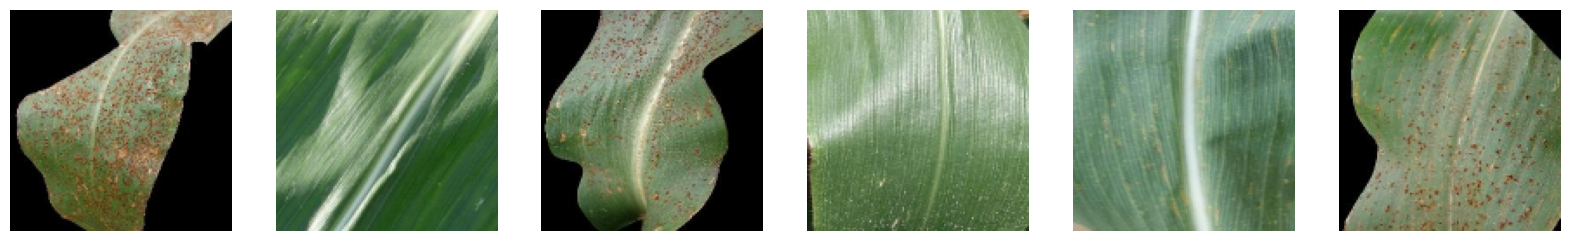

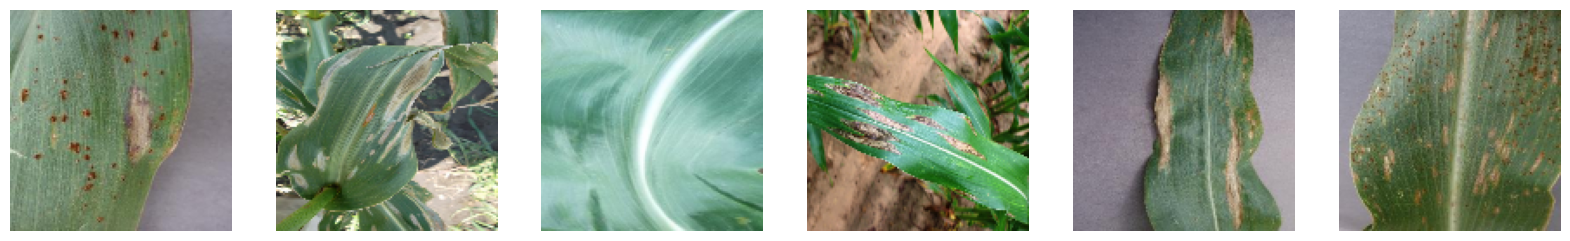

In [39]:
X_train_RGB = np.array(X_train).reshape(-1, 128, 128, 3)
display_images(X_train_RGB)

X_val_RGB = np.array(X_val).reshape(-1, 128, 128, 3)
display_images(X_val_RGB)

In [40]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

scaler = scaler.fit(np.array(X_train))
X_train_np = scaler.transform(np.array(X_train))
X_val_np = scaler.transform(np.array(X_val))

In [41]:
import numpy as np

y_train = y_train.to_numpy().reshape(len(y_train), 1)  
y_val = y_val.to_numpy().reshape(len(y_val), 1)        

print("Shape of train X:", X_train_RGB.shape)  
print("Shape of train Y:", y_train.shape)      
print("Shape of val X:", X_val_RGB.shape)      
print("Shape of val Y:", y_val.shape)          

print("Shape of train X:", X_train_RGB.shape)  
print("Shape of train Y:", y_train.shape)      
print("Shape of val X:", X_val_RGB.shape)      
print("Shape of val Y:", y_val.shape)          

Shape of train X: (3629, 128, 128, 3)
Shape of train Y: (3629, 1)
Shape of val X: (1210, 128, 128, 3)
Shape of val Y: (1210, 1)
Shape of train X: (3629, 128, 128, 3)
Shape of train Y: (3629, 1)
Shape of val X: (1210, 128, 128, 3)
Shape of val Y: (1210, 1)


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.utils import to_categorical


In [45]:
input_shape = X_train_RGB[0].shape  
num_train_images = len(X_train_RGB) 
num_classes = 4                     

print(f'Single image shape: {input_shape}')       
print(f'Number of train images: {num_train_images}')  

Single image shape: (128, 128, 3)
Number of train images: 3629


## 4. Models

### 4.1 CNN

In [46]:
model = Sequential()
model.add(Input(shape=input_shape))
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))
opt = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()
train_datagen = ImageDataGenerator(rotation_range = 10, # rotation
width_shift_range = 0.1, # horizontal shift
height_shift_range = 0.1,
zoom_range = 0.1) # zoom
monitor_val_loss = EarlyStopping(monitor = "val_loss",
min_delta = 1e-3,
patience = 20, 
verbose = 1,
mode = "auto",
restore_best_weights = True)
epochs = 100
batch_size = 64
training_data = train_datagen.flow(X_train_RGB, to_categorical(y_train), batch_size = batch_size)
validation_data = (X_val_RGB, to_categorical(y_val))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    14,745,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,824,260 (56.55 MB)

 Trainable params: 14,824,260 (56.55 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
print("Training data shape:", X_train_RGB.shape)  # Expected: (num_samples, 128, 128, 3)
print("Training label shape:", to_categorical(y_train).shape)  # Expected: (num_samples, num_classes)
print("Validation data shape:", X_val_RGB.shape)
print("Validation label shape:", to_categorical(y_val).shape)

print("\nNumber of samples in each category:")
print(np.unique(y_train, return_counts=True))

Training data shape: (3629, 128, 128, 3)
Training label shape: (3629, 4)
Validation data shape: (1210, 128, 128, 3)
Validation label shape: (1210, 4)

Number of samples in each category:
(array([0, 1, 2, 3]), array([829, 947, 997, 856]))


In [48]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (3629, 49152)
y_train shape: (3629, 1)
X_val shape: (1210, 49152)
y_val shape: (1210, 1)


Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.2906 - loss: 14.0543 - val_accuracy: 0.3504 - val_loss: 1.3831
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.3281 - loss: 1.3393 - val_accuracy: 0.3678 - val_loss: 1.3794
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.3400 - loss: 1.3726 - val_accuracy: 0.3711 - val_loss: 1.3703
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.3906 - loss: 1.2650 - val_accuracy: 0.3868 - val_loss: 1.3632
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.4295 - loss: 1.2207 - val_accuracy: 0.4678 - val_loss: 1.2610
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.5312 - loss: 1.0398 - val_accuracy: 0.4942 - val_loss: 1.2575
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.5077 - loss: 1.1227 - val_accuracy: 0.4884 - val_loss: 1.1466
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.4531 - loss: 1.0631 - val_accuracy: 0

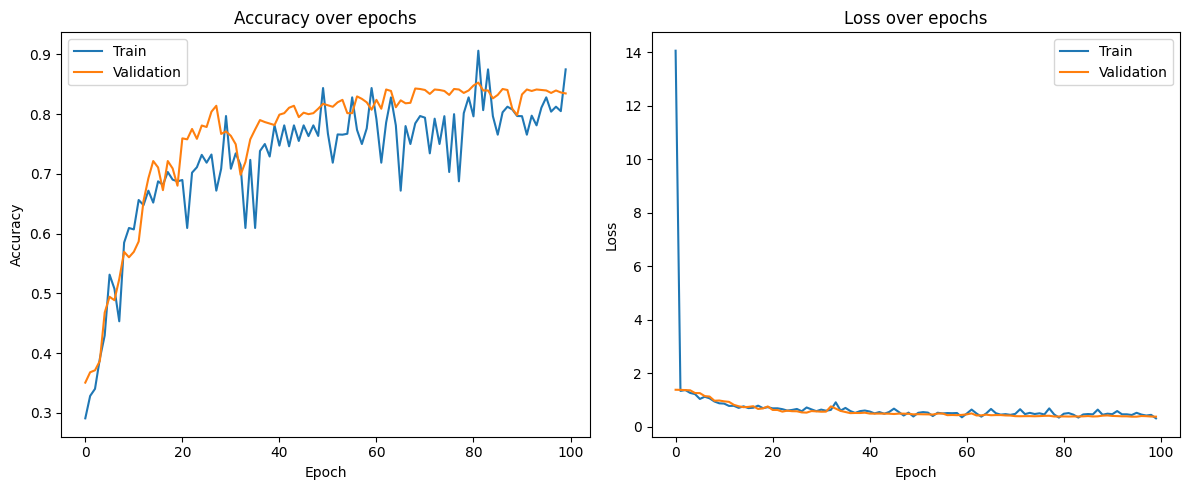

In [34]:
from tensorflow.keras.callbacks import History
history = model.fit(
    training_data,
    epochs=epochs,
    steps_per_epoch=num_train_images // batch_size,
    validation_data=validation_data,
    callbacks=[monitor_val_loss, History()],  
    verbose=1
)

def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy over epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)  

In [62]:
def scale_and_reshape_images(flattened_images_lst=[]):
    images_scaled_RGB_lst = []
    for images in flattened_images_lst:
        images_scaled = scaler.transform(images)
        images_scaled_RGB = np.array(images_scaled).reshape(-1, 128, 128, 3)
        images_scaled_RGB_lst.append(images_scaled_RGB)
    return images_scaled_RGB_lst

def display_image(image_single):
    image_flat = image_single.reshape(1, -1)
    image_inv = scaler.inverse_transform(image_flat)
    image_reshaped = image_inv.reshape(128, 128, 3)
    image = image_reshaped.astype(np.uint8)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

def interpret_model_prediction(predictions):
    pred_lst = predictions[0,:].tolist()
    max_proba = max(pred_lst)
    pred_idx = pred_lst.index(max_proba)
    return pred_idx, max_proba

def make_predictions(scaled_RGB_lst, image_class='', image_idx=int):
    class_val = classes[image_class]
    image_single = scaled_RGB_lst[class_val][image_idx]
    pred = model.predict(image_single.reshape(1, 128, 128, 3))
    pred_class, confidence = interpret_model_prediction(pred)
    display_image(image_single)
    print(f"Actual: {image_class}")
    print(f"Predicted: {list(classes.keys())[pred_class]}")
    print(f'Confidence: {round(confidence, 4)}')
    

Num of images: 20
Single image shape after flattening: (49152,)
Num of images: 20
Single image shape after flattening: (49152,)
Num of images: 20
Single image shape after flattening: (49152,)
Num of images: 20
Single image shape after flattening: (49152,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


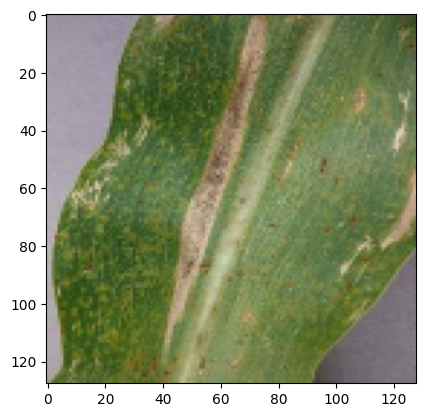

Actual: Blight
Predicted: Gray_Leaf_Spot
Confidence: 0.2767
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


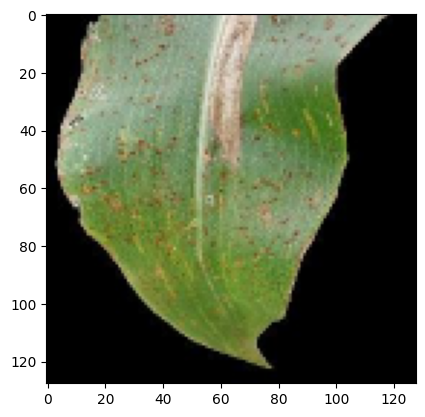

Actual: Common_Rust
Predicted: Gray_Leaf_Spot
Confidence: 0.2844
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


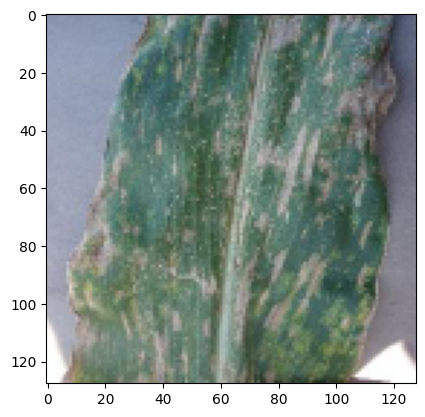

Actual: Gray_Leaf_Spot
Predicted: Gray_Leaf_Spot
Confidence: 0.2808
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


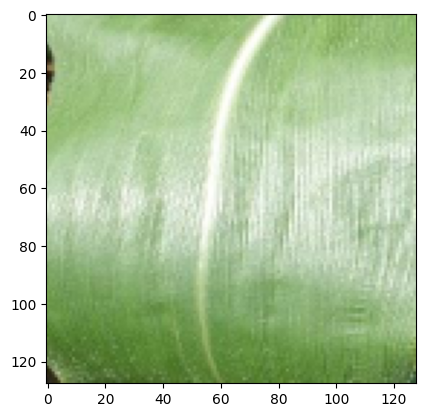

Actual: Healthy
Predicted: Gray_Leaf_Spot
Confidence: 0.2919


In [63]:
images_lst_array = []
for images in test_images:
    flattened = flatten_images(images)  
    images_lst_array.append(flattened)

images_scaled_RGB_lst = scale_and_reshape_images(images_lst_array)

class_keys = list(classes.keys())

image_idx = 2
for key in class_keys:
    make_predictions(images_scaled_RGB_lst, key, image_idx)



In [64]:
model.save("disease_detector_model.keras")

In [65]:
plt.savefig("plot.png") 

<Figure size 640x480 with 0 Axes>

### 4.2 SVM

In [66]:
X_train_features = X_train_RGB.reshape(X_train_RGB.shape[0], -1)  
X_val_features = X_val_RGB.reshape(X_val_RGB.shape[0], -1)

In [67]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear'))
cv_scores = cross_val_score(svm_model, X_train_features, y_train, cv=5)  
print("SVM Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

SVM Cross-Validation Scores: [0.87878788 0.86501377 0.87190083 0.86225895 0.86482759]
Mean CV Score: 0.8685578037427568
